In [1]:
import os
import sys
import numpy as np
from os.path import join, splitext
import copy
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.signal import savgol_filter, periodogram
%matplotlib inline

pylab.rcParams['figure.figsize'] = 12, 9

from Wavefront import Telescope
from Wavefront import Image
from Wavefront import WaveFitter
from Wavefront import TELESCOPE_DICT
from Wavefront import waveplot, wavecorr, utils

simfile = 'aratmos_rate1000.0_exptime60.0.fits'
datafile = 'ugp_When_2015.11.6_4.48.23_poldm_phase.fits'
directory = '/nfs/slac/g/ki/ki19/lsst/snyder18'
telescope_name = 'GPI'
pixscale = 7.77/43

/nfs/slac/g/ki/ki06/roodman/Software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
sim_dict = utils.filepath_library(simfile, directory, telescope_name)
data_dict = utils.filepath_library(datafile, directory, telescope_name)

for key, value in sim_dict.iteritems():
    print key, '\n', value

zernikes 
/nfs/slac/g/ki/ki19/lsst/snyder18/Results/aratmos_rate1000.0_exptime60.0_GPI/aratmos_rate1000.0_exptime60.0_GPI_coefficients.csv
GraphsDir 
/nfs/slac/g/ki/ki19/lsst/snyder18/Results/aratmos_rate1000.0_exptime60.0_GPI/Graphs
ResultsDir 
/nfs/slac/g/ki/ki19/lsst/snyder18/Results/aratmos_rate1000.0_exptime60.0_GPI
graphs 
/nfs/slac/g/ki/ki19/lsst/snyder18/Results/aratmos_rate1000.0_exptime60.0_GPI/Graphs/aratmos_rate1000.0_exptime60.0_GPI
DataDir 
/nfs/slac/g/ki/ki19/lsst/snyder18/Data/aratmos_rate1000.0_exptime60.0.fits
Base 
aratmos_rate1000.0_exptime60.0_GPI
periodograms 
/nfs/slac/g/ki/ki19/lsst/snyder18/Results/aratmos_rate1000.0_exptime60.0_GPI/aratmos_rate1000.0_exptime60.0_GPI_periodograms.csv


In [3]:
sim_periodograms = np.loadtxt(sim_dict['periodograms'], dtype=np.float64, delimiter=',')
data_periodograms = np.loadtxt(data_dict['periodograms'], dtype=np.float64, delimiter=',')

In [4]:
sim_periodograms.shape

(38, 30001)

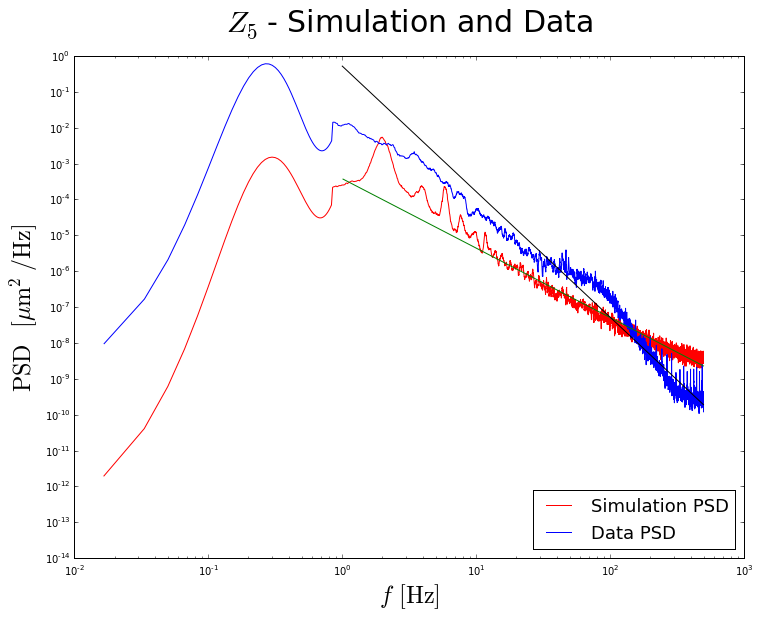

In [5]:
Z_noll = 5

sim_smoothed = 10**savgol_filter(np.log10(sim_periodograms[Z_noll,:]), 101, 5)
data_smoothed = 10**savgol_filter(np.log10(data_periodograms[Z_noll,:]), 101, 5)

## Perform linear fit to smoothed PSD
sim_par = np.polyfit(np.log10(sim_periodograms[0,sim_periodograms[0,:]>1]), 
                     np.log10(((0.5/(2*np.pi))**2)*sim_smoothed[sim_periodograms[0,:]>1.]), 1)
sim_slope = sim_par[0]
sim_intercept = sim_par[1]

data_par = np.polyfit(np.log10(data_periodograms[0,data_periodograms[0,:]>1]), 
                     np.log10(data_smoothed[data_periodograms[0,:]>1.]), 1)
data_slope = data_par[0]
data_intercept = data_par[1]

fig = plt.figure()
ax = fig.add_subplot(111)
img = ax.loglog(sim_periodograms[0,:], ((0.5/(2*np.pi))**2)*sim_smoothed, 'r',
                data_periodograms[0,:], data_smoothed, 'b',
                sim_periodograms[0,sim_periodograms[0,:]>1.], 
                (10**sim_intercept)*sim_periodograms[0, sim_periodograms[0,:]>1.]**sim_slope, 'g',
                data_periodograms[0,data_periodograms[0,:]>1.], 
                (10**data_intercept)*data_periodograms[0, data_periodograms[0,:]>1.]**data_slope, 'black')
ax.legend(['Simulation PSD', 'Data PSD'], loc=4, fontsize=18)
ax.set_ylabel(r'$\mathrm{{PSD}} \,\, [\mu\mathrm{{m}}^2/\mathrm{{Hz}}]$'.format(Z_noll), fontsize=24)
ax.set_xlabel(r'$f$ $\mathrm{[Hz]}$', fontsize=24)
ax.set_title(r'$Z_{{{0}}}$ - Simulation and Data'.format(Z_noll), fontsize=30, y=1.04)

In [ ]:
a